### **Importing The required libraries**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

We download the pre-trained word embeddings.

In [21]:
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.6B.zip \
    -O /tmp/glove.6B.zip

--2024-10-16 17:02:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-16 17:02:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-16 17:02:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


Next we extract them into a temporary folder:

In [22]:
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

### **Data preparation**

In [23]:
df = pd.read_csv('your_updated_dataset.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Size,Price
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,M,187.350664
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,S,80.648631
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,L,130.487234
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,S,186.337842
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,M,195.567178


In [24]:
df = df[['Review Text', 'Recommended IND']]
df.head()

,Review Text,Recommended IND
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [25]:
text = df.rename(columns={"Recommended IND": "Sentiment"})
text.head()

,Review Text,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [26]:
text.shape

(23486, 2)

In [27]:
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review Text  22641 non-null  object
 1   Sentiment    23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


In [28]:
df.isnull().sum(axis = 0)

,0
Review Text,845
Recommended IND,0


In [29]:
df.dropna(inplace = True)
df.isnull().sum()

<ipython-input-29-27f6a7259cd5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


,0
Review Text,0
Recommended IND,0


In [30]:
text['Sentiment'].value_counts()

,count
Sentiment,
1,19314
0,4172


Spliting the data into train and test sets:

In [31]:
X = text['Review Text']
y = text['Sentiment']

X_train_sentences, X_test_sentences, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

**Tokenizing the words:**

Cause our data is text data, it has to be converted into numerical form since that’s what the deep learning model expects.
To convert sentences into numerical representations we use `Tokenizer`, which removes punctuation marks and special characters and converts the sentence to lowercase letter.

In [32]:
vocab_size = 5000
embedding_dim = 16
max_len = 100
trunction_type='post'
padding_type='post'
oov_token = "<OOV>"

In [35]:
X_train_sentences = X_train_sentences.astype(str)
tokenize = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenize.fit_on_texts(X_train_sentences)

The word index show us how words are mapped into numbers:

In [36]:
word_index = tokenize.word_index

By use `texts_to_sequences` from the tokenizer we convert the words into sequences so that a complete sequence of numbers can represent every sentence.

In [38]:
# Before converting to sequences, fill NaN values with an empty string or a placeholder:
X_test_sentences = X_test_sentences.fillna('')  # Or X_test_sentences.fillna('<MISSING>')

X_test = tokenize.texts_to_sequences(X_test_sentences.astype(str)) # Apply astype(str) to the Series itself.

In [39]:
X_train = tokenize.texts_to_sequences(X_train_sentences)
X_test = tokenize.texts_to_sequences(X_test_sentences)

In [40]:
X_train[9:11]

[[8,
  7,
  5,
  73,
  26,
  6,
  3623,
  247,
  72,
  3,
  66,
  1088,
  4,
  5,
  92,
  23,
  16,
  20,
  580,
  17,
  3,
  439,
  44,
  419,
  6,
  11,
  6,
  7,
  73,
  4,
  2,
  2155,
  12,
  2,
  494,
  189,
  6,
  767,
  277],
 [2, 48, 16, 5, 54, 755, 72, 6, 77, 138, 11, 3, 29, 6]]

Now we add padding to our data by using `pad_sequences`function to make it uniform.

In [41]:
X_train_pad = pad_sequences(X_train,maxlen=max_len, padding=padding_type,
                            truncating=trunction_type)

X_test_pad = pad_sequences(X_test,maxlen=max_len, padding=padding_type,
                           truncating=trunction_type)

### **GloVe Embeddings**
We use pre-trained word embeddings to create own embedding layer. We loading the Glove embeddings and append them to a dictionary.

Next we use this dictionary to create an embedding matrix for each word in the training set.

In [42]:
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    try:
       coefs = np.asarray(values[1:], dtype='float32')
       embeddings_index[word] = coefs
    except ValueError:
       pass
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [43]:
num_words = len(word_index) + 1

embedding_matrix = np.zeros((num_words, max_len))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Finally we create the embedding layer:


In [44]:
embedding_layer = Embedding(num_words,
                            max_len,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### **Build the model**
We create a model using embedding layer and Bidirectional LSTM layers. Bidirectional LSTMs are supported in Keras via the Bidirectional layer wrapper and it  takes a recurrent layer (e.g. the first LSTM layer) as an argument.

In [45]:
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(embedding_dim, return_sequences=True)),
    Bidirectional(LSTM(embedding_dim)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,350,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,350,800 (5.15 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,350,800 (5.15 MB)

We train the model for 10 epoch:

In [46]:
history = model.fit(X_train_pad, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test_pad, y_test),
                    verbose=1)

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8222 - loss: 0.4464 - val_accuracy: 0.8238 - val_loss: 0.4272
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.8329 - loss: 0.3619 - val_accuracy: 0.8612 - val_loss: 0.3193
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.8558 - loss: 0.3221 - val_accuracy: 0.8748 - val_loss: 0.3004
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8705 - loss: 0.2993 - val_accuracy: 0.8759 - val_loss: 0.2871
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8780 - loss: 0.2843 - val_accuracy: 0.8878 - val_loss: 0.2721
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8935 - loss: 0.2609 - val_accuracy: 0.8865 - val_loss: 0.2717
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8964 - loss: 0.2463 - val_accuracy: 0.8897 - val_loss: 0.2648
Epoch 8/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9041 - loss: 0.2344 - 

Predictions on a test set:

In [47]:
loss, accuracy = model.evaluate(X_test_pad,y_test)
print('Test accuracy :', accuracy)

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8913 - loss: 0.2679
Test accuracy : 0.8952745795249939


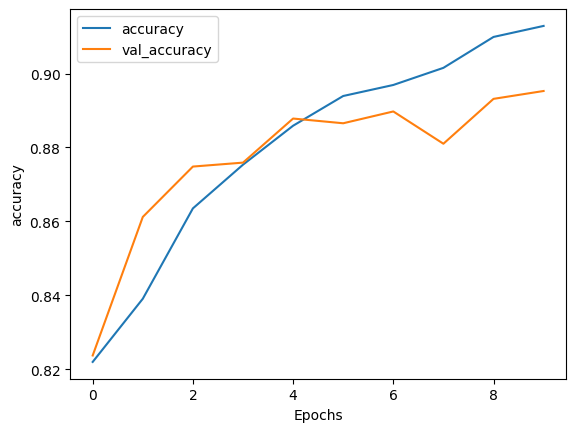

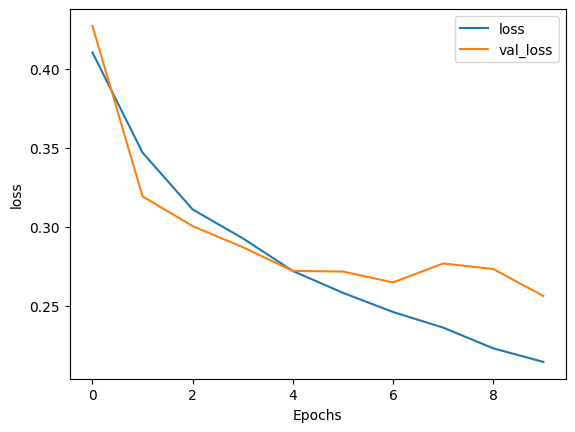

In [48]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [50]:
y_pred_model = model.predict(X_test_pad)
y_pred_model = (y_pred_model > 0.5).astype(int)  # Threshold of 0.5 for binary classification
accuracy_model = accuracy_score(y_test, y_pred_model)
print("Model 1 Test Accuracy:", accuracy_model)


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Model 1 Test Accuracy: 0.8952745849297573


In [51]:
model.save("sentiment_model.h5")

**Model 2**

We also test a second model with a Dropout layer for decrease overfitting and  we increase number of epochs to 20.

In [53]:
model2 = Sequential([
    embedding_layer,
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model2.compile(loss='binary_crossentropy',
               optimizer=optimizer,
               metrics=['accuracy'])

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │       1,350,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,350,800 (5.15 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,350,800 (5.15 MB)

In [54]:
callbacks = EarlyStopping(monitor = 'val_accuracy',
                          mode = 'max',
                          patience = 10,
                          verbose = 1)

In [55]:
history2 = model2.fit(X_train_pad, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_test_pad, y_test),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.7909 - loss: 0.5394 - val_accuracy: 0.8238 - val_loss: 0.3946
Epoch 2/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8258 - loss: 0.4112 - val_accuracy: 0.8527 - val_loss: 0.3573
Epoch 3/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8476 - loss: 0.3761 - val_accuracy: 0.8412 - val_loss: 0.3624
Epoch 4/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8481 - loss: 0.3717 - val_accuracy: 0.8616 - val_loss: 0.3265
Epoch 5/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8559 - loss: 0.3484 - val_accuracy: 0.8638 - val_loss: 0.3191
Epoch 6/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8663 - loss: 0.3330 - val_accuracy: 0.8697 - val_loss: 0.3076
Epoch 7/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8705 - loss: 0.3243 - val_accuracy: 0.8734 - val_loss: 0.3011
Epoch 8/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8704 - loss: 0.3175 - 

Predictions:

In [56]:
loss, accuracy = model2.evaluate(X_test_pad,y_test)
print('Test accuracy :', accuracy)

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8703 - loss: 0.2868
Test accuracy : 0.8780332207679749


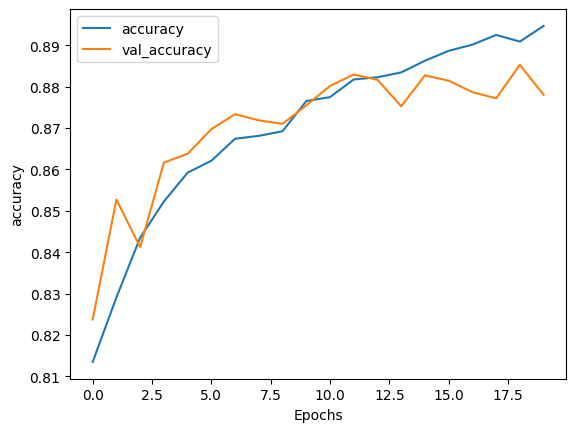

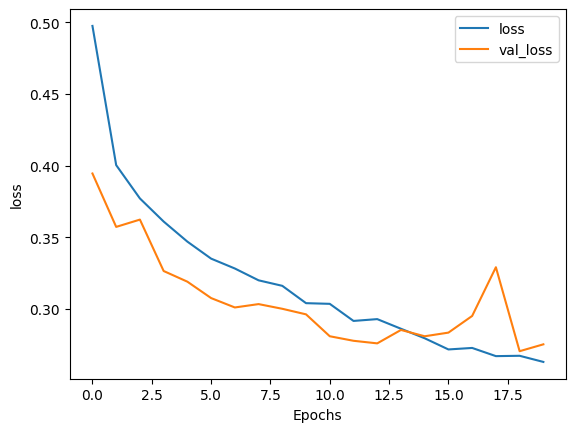

In [57]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

In [58]:
y_pred_model2 = model2.predict(X_test_pad)
y_pred_model2 = (y_pred_model2 > 0.5).astype(int)  # Threshold of 0.5 for binary classification
accuracy_model2 = accuracy_score(y_test, y_pred_model2)
print("Model 2 Test Accuracy:", accuracy_model2)


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Model 2 Test Accuracy: 0.8780332056194126


In [59]:
model2.save("sentiment_model2.h5")